In [1]:
import pandas as pd
from pandas import Timestamp
import numpy as np
import scipy.stats as stats
from datetime import datetime
from pytz import timezone

import itertools

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline

sns.set_style('whitegrid')
pd.set_option('display.max_columns', 100)

In [2]:
full_history = pd.read_json('data/history_clean.json')

if full_history['timestamp'].max().tz is None:
    full_history['timestamp'] = pd.to_datetime(full_history['timestamp'], utc=True)
    full_history['timestamp'] = full_history['timestamp'].apply(lambda t: t.tz_convert('US/Pacific'))

In [3]:
artists = pd.read_json('data/artists_clean.json')

In [4]:
def get_unique():
    unique_history = full_history.drop('timestamp', axis=1)
    return unique_history.drop_duplicates('id')

## When do I listen to music?

It's unlikely I'm always listening to music, 24/7. So what does the time frame of my listening actually look like?

Above I mentioned that on average I listen to about 78 songs per day. Since I've started recording my listening, how have I deviated from that? The graph below shows the "rate" of my music listening, overlaid with a linear estimation of exactly 78 songs per day. Around late March was Finals week and the beginning of my Spring Break, hence the steep rise in music listening (less time in class, more time in the library/relaxing at home). Following that is a flatline of music listening, which corresponds to a vacation I took with my girlfriend. I was spending time exploring a new place and being present with her, instead of listening to music.

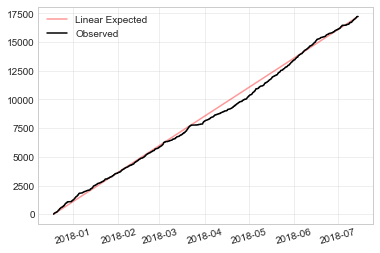

In [5]:
dates = full_history['timestamp'].sort_values().reset_index(drop=True)
plt.xticks(rotation=15)
plt.plot([min(full_history['timestamp']), max(full_history['timestamp'])], 
         [0, max(dates.index)], 
         'r-', alpha=0.4, label='Linear Expected')
plt.plot(dates.values, dates.index, c='k', label='Observed')
plt.legend()
plt.grid(alpha=0.4)

How does my music collection look in terms of song length?

In [6]:
print(pd.Series(full_history['duration']).describe())
full_history.sort_values('duration')[['name', 'duration']].tail(5)

count    17235.000000
mean         3.876867
std          1.448328
min          0.528667
25%          3.139500
50%          3.665033
75%          4.348950
max         41.983333
Name: duration, dtype: float64


,name,duration
4464,Sea Drift,26.070000
12306,"Tod und Verklärung Op.24, TrV 158",27.024000
2261,"Rag Bhimpalasi: Alap, Jod, Jhala",41.074900
4395,"Rag Bhimpalasi: Alap, Jod, Jhala",41.074900
3574,Rag Bhimpalasi,41.983333


During the average week, when do I listen to music?

In [7]:
def _averageDatetimeFrequency(df, hour_inc):
    hour_bins = np.arange(0, 24+hour_inc, hour_inc)
    hour_labels = np.arange(hour_inc, 24+hour_inc, hour_inc)

    df['time_bin'] = pd.cut(df['hour_decimal'], bins=hour_bins, labels=hour_labels)
    
    history_time_bivar = df.groupby(['weekday', 'time_bin'], axis=0)
    return history_time_bivar.size().unstack().fillna(0)

def plotAverageDatetimeFrequency(data, title='', fs=(12,5), hour_inc=0.5):
    plt.subplots(figsize=fs)
    plt.title('Average Listening Date-time Frequency{}'.format(title))
    g = sns.heatmap(_averageDatetimeFrequency(data, hour_inc), cmap="Blues", robust=True)
    plt.xlabel('Time Bin')
    plt.ylabel('Weekday')
    g.set(yticklabels=['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']); # use ; to suppress output

The heatmap below attempts to answer the above question. Darker squares are hours on a specific day of the week in whih I've listened to a lot of music. Notice the lack of 4am-6am, where I have never listened to music.

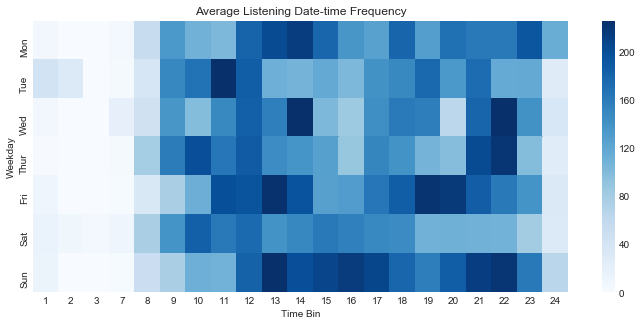

In [8]:
plotAverageDatetimeFrequency(full_history, hour_inc=1)

In [ ]:
inc = 1

hour_labels = np.arange(inc, 24+inc, inc)
day_bins = np.arange(0,7)

genres_matrix = []

w = []
for day in day_bins:
    d = []
    for hour in hour_labels:
        genres = full_history.loc[(full_history['weekday'] == day) & (full_history['time_bin'] == hour), 'genres']
        
        if list(genres):
            unique_genres, genres_counts = np.unique(list(itertools.chain(*genres.dropna())), return_counts=True)
            i, = np.where(genres_counts==genres_counts.max())
            i = i[0]
            d.append(str(unique_genres[i]))
        else:
            d.append('none')
    w.append(d)
    
d = pd.DataFrame(w)

In [ ]:
u = np.unique(d)
u = dict(zip(u, range(len(u))))
d = d.replace(u)

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
im = plt.imshow(d, cmap='tab20b', aspect=3)

cb = fig.colorbar(im)
cb.set_ticks(list(u.values()))
cb.set_ticklabels(list(u.keys()))  # put text labels on them

# Major ticks
ax.set_xticks(np.arange(0, 24, 1));
ax.set_yticks(np.arange(0, 7, 1));

# Minor ticks
ax.set_xticks(np.arange(-.5, 23, 1), minor=True);
ax.set_yticks(np.arange(-.5, 6, 1), minor=True);

# Gridlines based on minor ticks
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
ax.grid(which='major', b=False)

ax.set_yticklabels(['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'])

plt.xlabel('Hour of the Day')
plt.ylabel('Weekday');

Are there artists I prefer at a certain time of day? Let's limit our search to artists who follow these requirements:

 1. if we lay out all the hours of the day that I've listened to a song by that artist, we get a vector (or array) of hours (in decimal). We only consider artists that have at most 3 hours between the 25% quantile hour and the 75% quantile hour. This ensures artists are truly localized to a certain time of the day
 2. out of all artists, let's find the 90% quantile of listen counts. In this case it happens to be 9 listens. We only consider artists that have an equivalent amount of listens or more than this. This ensures I actually do listen to this artist. We don't want some artist with only 2 listens being included in our results.

In [9]:
MAX_SPREAD = 3.0
MIN_COUNT = np.percentile(artists['listens'], 90)
MAX_SPREAD, MIN_COUNT

(3.0, 10.0)

In [10]:
def is_compact(arr):
    prc25, prc75 = np.percentile(arr, [25, 75])
    return (prc75 - prc25) <= MAX_SPREAD

selected_artists = []

for artist in artists.itertuples():
    track_hours = []
        
    if artist.listens < MIN_COUNT: continue
        
    for track in full_history.itertuples():
        if artist.id in track.artists:
            track_hours.append(track.hour_decimal)
            
    if is_compact(track_hours):
        selected_artists.append([artist.artist, artist.id, np.median(track_hours)])

artists_dayhours = pd.DataFrame(selected_artists, columns=['artist', 'id', 'hour'])

Interestingly, we see a handul of artists are in fact localized to a certain time of the day for me. For example, we see some classic rock bands (The Kinks, The Who) localized to the morning and afternoon. I have a tendency to listen to classical music before bed, hence Gould, Vivaldi, and Debussy all 9pm and later artists.

/Users/alex/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


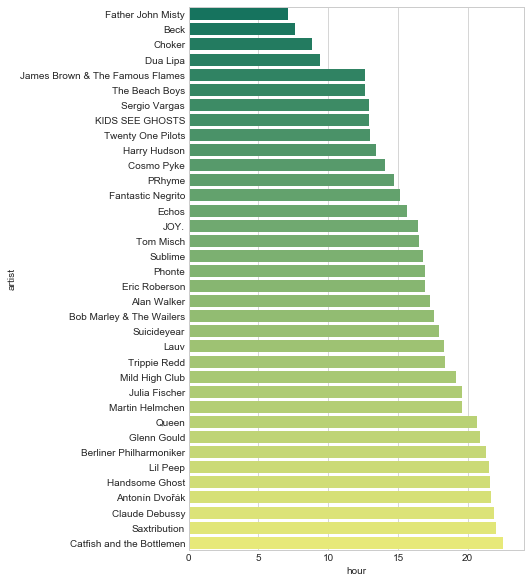

In [11]:
a = artists_dayhours.sort_values('hour')
plt.subplots(figsize=(6,10))
plt.xlim([0,24])
sns.barplot(a['hour'], a['artist'], orient='h', palette='summer')

When I listen to music, how much do I listen to? We create the idea of a listening *cluster*, which is a period of time in which I listened to consecutive music. In one cluster, I might listen to just a single song, or 20 songs back-to-back, or a few hours of music on end.

We examine this by creating clusters which depend on the time between one song at time $t_i$ and the next song at time $t_{i+1}$, and comparing this value to the duration of the song at $t_i$ plus some time extension. This extension allows little breaks in listening to be had (e.g. pausing in the middle of the song for a minute), but still allows it to continue the chain of songs.

$$C = \{t\in T \mid t_{i+1} - t_i < \epsilon \textrm{ and } t_i \leq t_{i+1}\}$$

where $T$ is the set of all song timestamps, and $t_i$ is the timestamp of some song such that the timestamp $t_{i+1}$ occurs next, $t_i \leq t_{i+1}$. $\Delta$ is equal to the duration of the song at time $t_i$ and $\epsilon$ is the cluster width extension variable ($\epsilon > 0$). Various cluster width extensions are shown in the graph below. A cluster $C$ is the set such that $\Delta + \epsilon$ is greater than the amount of time between the timestamps $t_{i+1}$ and $t_i$.

The results resemble a logarithmic graph, and are somewhat linear when log transformed. When the cluster width extension, $\epsilon$, is 5 minutes, the average cluster duration is about 36 minutes. This is interpreted as, if we consider a grouping of listening to occur when one song is played within five minutes of the end of the previous song, I will listen for about 36 minutes. After that, I'll take a break of at least five minutes.

In [12]:
full_history['timestamp_64'] = pd.DatetimeIndex(full_history['timestamp']).view('int64') // pd.Timedelta(1, unit='s')
T = full_history.copy()
T = T.sort_values('timestamp_64', ascending=True)
T = T.reset_index(drop=True)

t_i1 = np.array(T.loc[1:, 'timestamp_64'])
t_i = np.array(T.loc[:len(T)-2, 'timestamp_64'])
raw_deltas = t_i1 - t_i

T.drop(0, axis=0, inplace=True)
T.loc[:, 'duration'] *= 60
T.loc[:, 'delta'] = np.array(raw_deltas)
# duration is the song duration in seconds
# delta is the number of seconds from the ith to the (i+1)th record

In [13]:
cluster_means = []
MAXIMUM_GAPS = np.arange(0,20)

for MAXIMUM_GAP in MAXIMUM_GAPS:
    clusters = []
    current_cluster = 0
    for row in T.itertuples():
        
        current_cluster += row.duration
        
        if row.delta > (MAXIMUM_GAP * 60):
            clusters.append(current_cluster)
            current_cluster = 0
            
    clusters.append(current_cluster)
    clusters = pd.Series(clusters) / 60
    cluster_means.append(round(np.mean(clusters), 1))

We see that as we increase the gap of time between one song and the song after, the clusters get longer and longer until the increase in cluster duration becomes linear. As interpretation: if we cluster together all songs that are at most 5 minutes apart, the average cluster of music is 20.9 minutes. At a 15 minute extension, clusters become 56 minutes long on average.

3.8768297957522586


0      3.9
1      4.0
2      4.4
3      6.6
4     12.6
5     21.1
6     29.3
7     35.1
8     39.5
9     43.9
10    46.8
11    48.9
12    51.4
13    53.3
14    55.1
15    56.5
16    57.8
17    58.8
18    60.0
19    61.2
dtype: float64

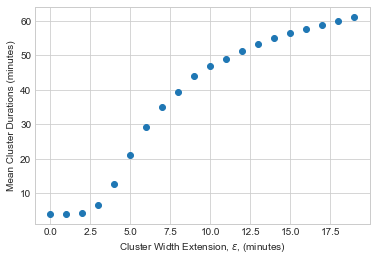

In [14]:
plt.xlabel('Cluster Width Extension, $\epsilon$, (minutes)')
plt.ylabel('Mean Cluster Durations (minutes)')
plt.scatter(x=MAXIMUM_GAPS, y=cluster_means)
print(np.mean(T.duration)/60)
pd.Series(cluster_means, index=MAXIMUM_GAPS)

What's the probability I'll play another song?

Let $X_t$ be the event that the $t^{th}$ song is played.

$$
P(X_t|X_{t-1}\cap...\cap X_0) = \frac{P(X_t\cap X_{t-1} \cap...\cap X_0)}{P(X_{t-1}\cap...\cap X_0)}
$$

The probability that I play one song is 1.0 due to the structure of the problem.

$$
P(X_0) = 1.0
$$

The probability that we listen the next song is 

$$
P(X_1|X_0) = \frac{P(X_1 \cap X_0)}{P(X_0)} = 
$$

In [159]:
ts = T['timestamp_64'].values


reach = 60 * 6
rng = np.zeros(100)

current = 0

total = 0

for i in range(len(ts)-2):
#     print(f'{i} to {i+1} \t  {ts[i+1] - ts[i] <= reach}')
    total += 1
    if ts[i+1] - ts[i] <= reach:
        current += 1
        rng[:current+1] += 1
    else:
        current = 0

/Users/alex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


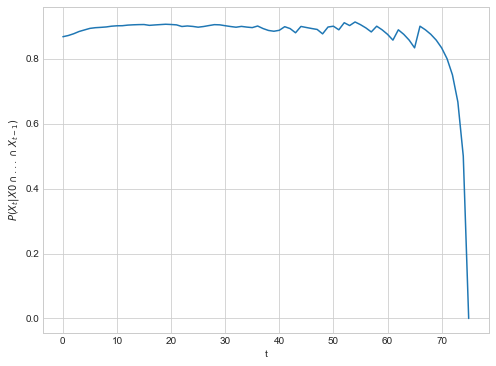

In [160]:
rng[0] = total
probs = rng / total

p = np.array([(probs[i+1] / probs[i]) for i in range(len(rng) - 1)])
plt.subplots(figsize=(8,6))
plt.ylabel(r'$P(X_t | X0 \cap ... \cap X_{t-1})$')
plt.xlabel('t')
plt.plot(range(len(rng) - 1), p);

In [161]:
p[~np.isnan(p)]

array([ 0.86757196,  0.87130435,  0.87678489,  0.88372297,  0.88853661,
        0.89328724,  0.89539383,  0.89641712,  0.89766719,  0.90003465,
        0.9012512 ,  0.9015378 ,  0.90334044,  0.90427485,  0.90487239,
        0.90512821,  0.9026204 ,  0.90388388,  0.90494792,  0.9059952 ,
        0.90524087,  0.90409357,  0.89909444,  0.90071942,  0.89936102,
        0.89698046,  0.8990099 ,  0.90198238,  0.9047619 ,  0.90418354,
        0.90149254,  0.89900662,  0.89686924,  0.89938398,  0.89726027,
        0.8956743 ,  0.90056818,  0.89274448,  0.8869258 ,  0.88446215,
        0.88738739,  0.89847716,  0.89265537,  0.87974684,  0.89928058,
        0.896     ,  0.89285714,  0.89      ,  0.87640449,  0.8974359 ,
        0.9       ,  0.88888889,  0.91071429,  0.90196078,  0.91304348,
        0.9047619 ,  0.89473684,  0.88235294,  0.9       ,  0.88888889,
        0.875     ,  0.85714286,  0.88888889,  0.875     ,  0.85714286,
        0.83333333,  0.9       ,  0.88888889,  0.875     ,  0.85

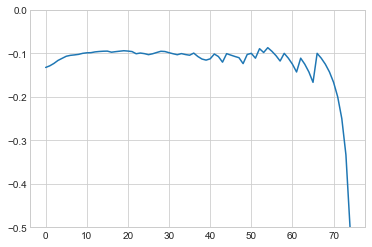

In [162]:
plt.plot(range(len(rng[rng > 0])-1), (rng[rng > 0][1:] - rng[rng > 0][:-1]) / rng[rng > 0][:-1])
plt.ylim([-0.5, 0]);

In [164]:
list(rng)

[17232.0,
 14950.0,
 13026.0,
 11421.0,
 10093.0,
 8968.0,
 8011.0,
 7173.0,
 6430.0,
 5772.0,
 5195.0,
 4682.0,
 4221.0,
 3813.0,
 3448.0,
 3120.0,
 2824.0,
 2549.0,
 2304.0,
 2085.0,
 1889.0,
 1710.0,
 1546.0,
 1390.0,
 1252.0,
 1126.0,
 1010.0,
 908.0,
 819.0,
 741.0,
 670.0,
 604.0,
 543.0,
 487.0,
 438.0,
 393.0,
 352.0,
 317.0,
 283.0,
 251.0,
 222.0,
 197.0,
 177.0,
 158.0,
 139.0,
 125.0,
 112.0,
 100.0,
 89.0,
 78.0,
 70.0,
 63.0,
 56.0,
 51.0,
 46.0,
 42.0,
 38.0,
 34.0,
 30.0,
 27.0,
 24.0,
 21.0,
 18.0,
 16.0,
 14.0,
 12.0,
 10.0,
 9.0,
 8.0,
 7.0,
 6.0,
 5.0,
 4.0,
 3.0,
 2.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]